In [1]:
import pyodbc
import sqlalchemy
import dotenv
import os

from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import axline
import seaborn as sns

from sklearn.model_selection import cross_val_predict, KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import SGDRegressor, LinearRegression, RANSACRegressor, ElasticNetCV, TheilSenRegressor, PassiveAggressiveRegressor
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor, StackingRegressor, ExtraTreesRegressor

from sklearn.base import BaseEstimator, RegressorMixin
import tensorflow as tf
import keras
from scikeras.wrappers import KerasRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import BaseCrossValidator

dotenv.load_dotenv()

sql_server = os.getenv('SQL_SERVER')
db_conn_string = f'DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={sql_server};DATABASE=japan;Trusted_Connection=yes;'
connection_url = sqlalchemy.engine.URL.create(
    "mssql+pyodbc", 
    query={"odbc_connect": db_conn_string}
)
engine = sqlalchemy.create_engine(connection_url)
df_japan = pd.read_sql('SELECT * FROM Transactions', engine)

df_japan_copy = df_japan.copy()

print(df_japan.head())

columns_to_encode = ['RealEstateType', 'Region', 'Prefecture', 'City', 'District', 'FrontageRoadType', 'FrontageRoadDirection', 'LandShape', 'PlanningType']
# Floorplan, CurrentUsage, PostTransactionUsage, Structure, BuildingYear either drop or input with unknown
columns_to_drop = ['ID', 'NearestStation', 'TransactionQuarter', 'Price', 'UnitPrice', 'FloorArea']
tentative_columns = ['FloorPlan', 'CurrentUsage', 'PostTransactionUsage', 'Structure', 'BuildingYear']
numerical_values = ['MinTimeToNearestStation', 'MaxTimeToNearestStation', 'Area', 'GreatArea', 'GreatFloorArea', 'FrontageRoadBreadth', 'PrewarBuilding', 'MaximumBuildingCoverageRatio', 'TransactionYear']

price = df_japan['Price']

df_japan = df_japan.drop(columns=columns_to_drop)
# df_japan = df_japan.drop(columns=tentative_columns)
print(df_japan.info())
print(df_japan.drop(columns=columns_to_encode).info())

df_japan = pd.get_dummies(df_japan, columns=columns_to_encode)
df_japan = pd.get_dummies(df_japan, columns=tentative_columns)
print(df_japan.info())
print(df_japan.shape)

X_train, X_test, y_train, y_test = train_test_split(df_japan, price, test_size=0.2)

       ID  RealEstateType  Region  Prefecture  City  District  NearestStation  \
0  435310              56    46.0          20   373   38907.0          2807.0   
1  435311              56    46.0          20   373   38907.0          2807.0   
2  435312              56    46.0          20   373   38907.0          2807.0   
3  435313              56    46.0          20   373   38173.0          2810.0   
4  435314              56    46.0          20   373   38173.0          2793.0   

   MinTimeToNearestStation  MaxTimeToNearestStation       Price  ...  \
0                     21.0                     21.0   4000000.0  ...   
1                     26.0                     26.0  21000000.0  ...   
2                     26.0                     26.0  10000000.0  ...   
3                     13.0                     13.0  12000000.0  ...   
4                      9.0                      9.0  37000000.0  ...   

   LandShape  BuildingYear  PrewarBuilding  Structure  CurrentUsage  \
0      11

In [2]:
print("Categorical:\n")
for encode_col in columns_to_encode:
    print(f"{encode_col} wartości unikalne: {df_japan_copy[encode_col].nunique()}")
for encode_col in tentative_columns:
    print(f"{encode_col} wartości unikalne: {df_japan_copy[encode_col].nunique()}")


print(f"columns_to_encode: {len(columns_to_encode)}")
print(f"columns_to_drop: {len(columns_to_drop)}")
print(f"tentative_columns: {len(tentative_columns)}")
print(f"numerical_values: {len(numerical_values)}")

Categorical:

RealEstateType wartości unikalne: 5
Region wartości unikalne: 4
Prefecture wartości unikalne: 2
City wartości unikalne: 34
District wartości unikalne: 3137
FrontageRoadType wartości unikalne: 14
FrontageRoadDirection wartości unikalne: 9
LandShape wartości unikalne: 9
PlanningType wartości unikalne: 16
FloorPlan wartości unikalne: 17
CurrentUsage wartości unikalne: 107
PostTransactionUsage wartości unikalne: 6
Structure wartości unikalne: 17
BuildingYear wartości unikalne: 76
columns_to_encode: 9
columns_to_drop: 6
tentative_columns: 5
numerical_values: 9


RidgeCV()
score:  0.3126814552931717


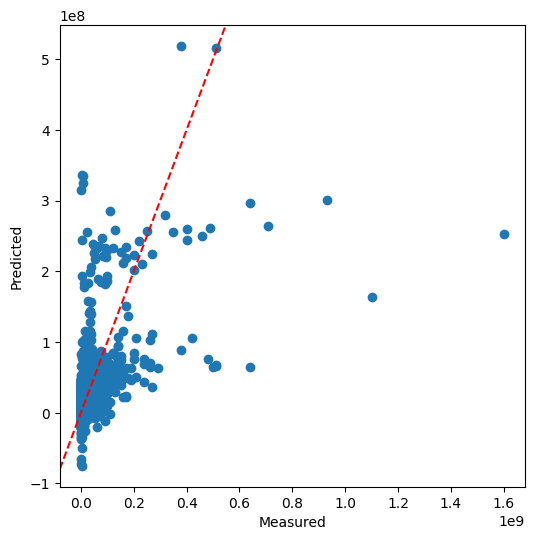

LarsCV()
score:  0.32115508183171515


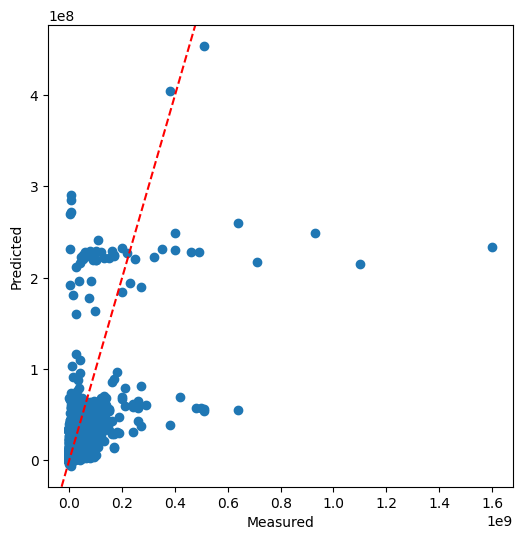

OrthogonalMatchingPursuitCV()
score:  0.30516608369848686


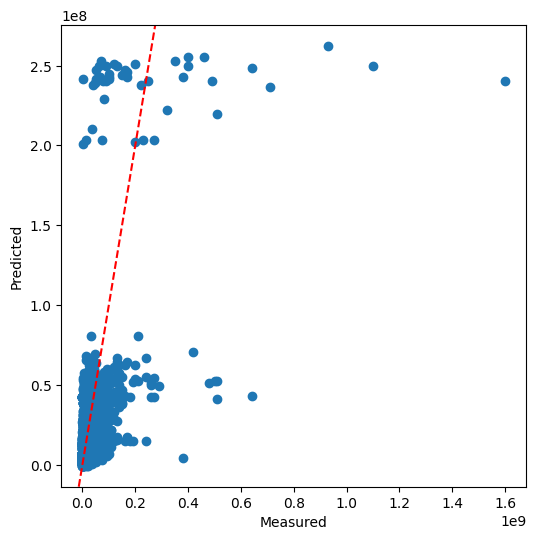

i:\miniconda\envs\inz--ai\Lib\site-packages\sklearn\linear_model\_glm\glm.py:283: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


PoissonRegressor()
score:  0.6715444878260102


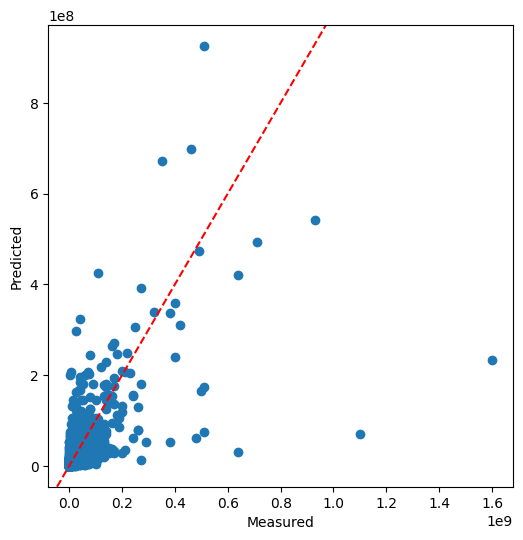

GammaRegressor()
score:  0.5235092872953793


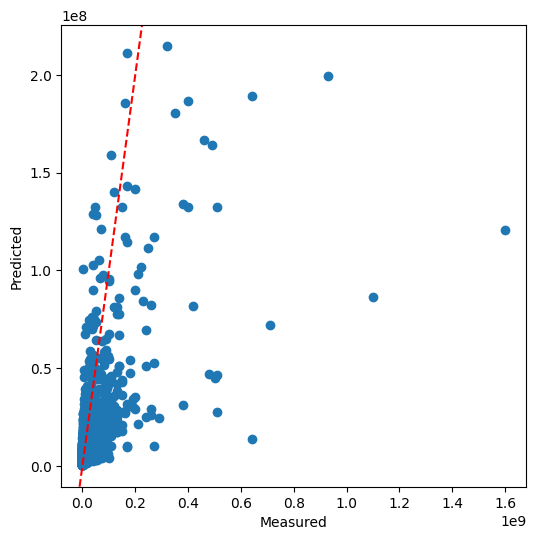

BayesianRidge()
score:  0.32306999506881184


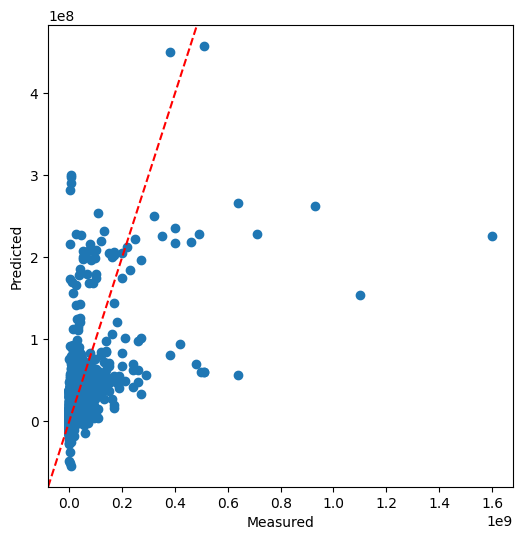

SGDRegressor()
score:  -3462854696.0192127


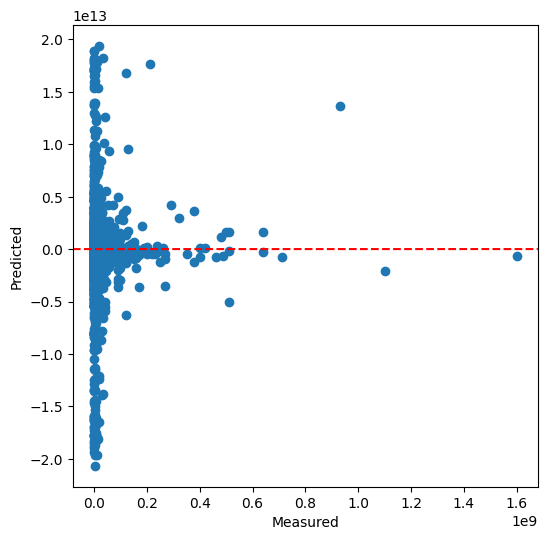

In [3]:
from sklearn.linear_model import RidgeCV, LarsCV, OrthogonalMatchingPursuitCV, HuberRegressor, PoissonRegressor, GammaRegressor, BayesianRidge 

new_list_of_models = [
    Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', RidgeCV())
    ]),
    Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', LarsCV())
    ]),
    Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', OrthogonalMatchingPursuitCV())
    ]),
    # Pipeline([
    #     ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    #     ('scaler', StandardScaler()),
    #     ('model', HuberRegressor())
    # ]),
     Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', PoissonRegressor())
    ]),
     Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', GammaRegressor())
    ]),
    #  Pipeline([
    #     ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    #     ('scaler', StandardScaler()),
    #     ('model', ARDRegression())
    # ]),
     Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', BayesianRidge())
    ]),
    Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', SGDRegressor())
    ]), 
    #  Pipeline([
    #     ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    #     ('scaler', StandardScaler()),
    #     ('model', TheilSenRegressor())
    # ]),
]

for model in new_list_of_models:
    hist = model.fit(X_train, y_train)
    print(model[2])
    print("score: ", hist.score(X_test, y_test))
    predicted = model.predict(X_test)
    actual = y_test

    f, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(actual, predicted)
    axline((0, 0), (1, 1), color='r', linestyle='--')
    ax.set_xlabel("Measured")
    ax.set_ylabel("Predicted")
    plt.show()

TweedieRegressor(max_iter=1500, power=2)
score:  0.5235092872953793


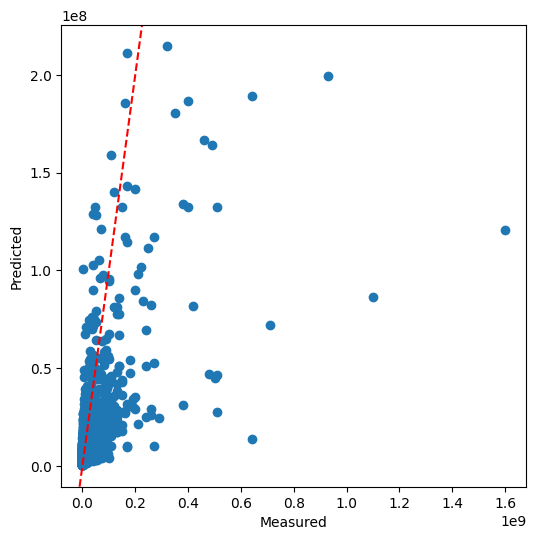

TweedieRegressor(max_iter=3000, power=1)
score:  0.674529268198517


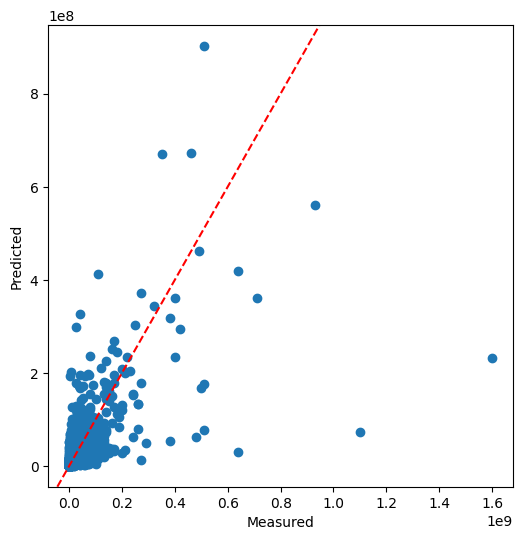

PoissonRegressor(max_iter=3000)
score:  0.674529268198517


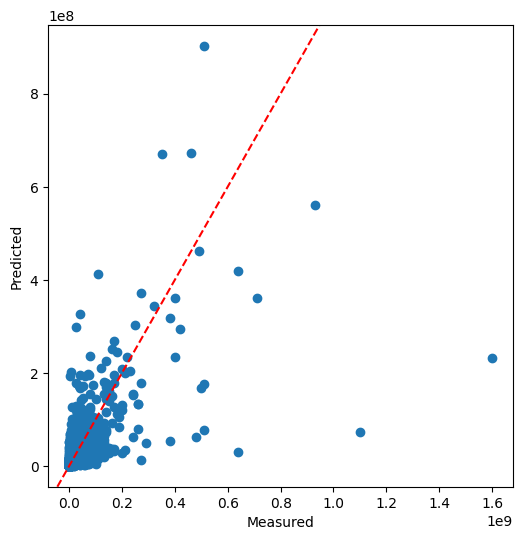

ExtraTreesRegressor()
score:  0.32803343324829337


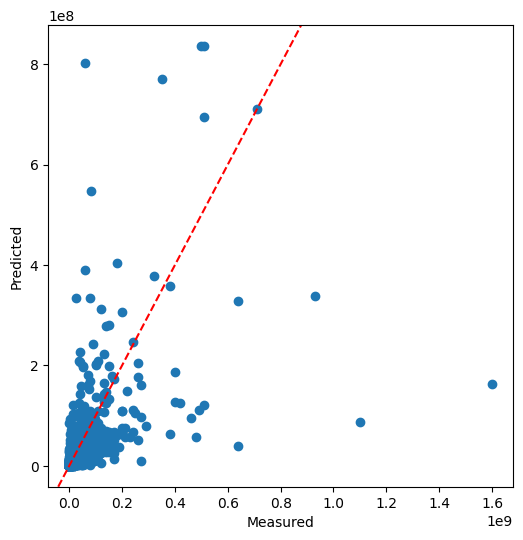

In [4]:
from sklearn.linear_model import TweedieRegressor, PoissonRegressor
from sklearn.ensemble import ExtraTreesRegressor

new2_list_of_models = [
    #  Pipeline([
    #     ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    #     ('scaler', StandardScaler()),
    #     ('model', TweedieRegressor())
    # ]),
    # Pipeline([
    #     ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    #     ('scaler', StandardScaler()),
    #     ('model', TweedieRegressor(power=3))
    # ]),
    # Pipeline([
    #     ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    #     ('scaler', StandardScaler()),
    #     ('model', TweedieRegressor(power=1.2, max_iter=500))
    # ]),
    Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', TweedieRegressor(power=2, max_iter=1500))
    ]),
    Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', TweedieRegressor(power=1, max_iter=3000))
    ]),
    Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', PoissonRegressor(max_iter=3000))
    ]),
    Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', ExtraTreesRegressor())
    ]),
]

for model in new2_list_of_models:
    hist = model.fit(X_train, y_train)
    print(model[2])
    print("score: ", hist.score(X_test, y_test))
    predicted = model.predict(X_test)
    actual = y_test

    f, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(actual, predicted)
    axline((0, 0), (1, 1), color='r', linestyle='--')
    ax.set_xlabel("Measured")
    ax.set_ylabel("Predicted")
    plt.show()

RANSACRegressor()
score:  -2.3849812621679468e+26


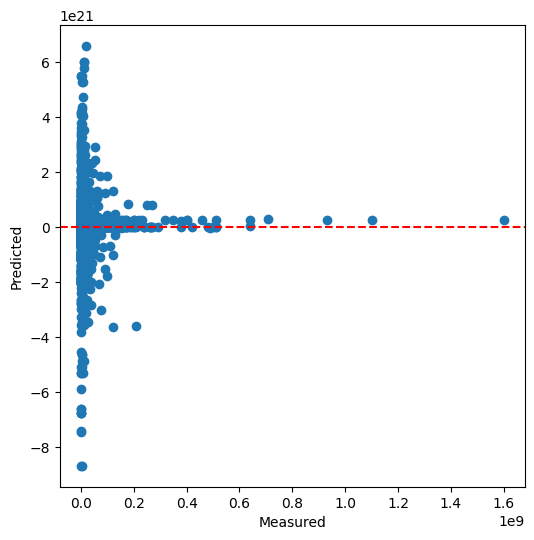

In [5]:
new3_list_of_models = [
    Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', RANSACRegressor())
    ]),
]

for model in new3_list_of_models:
    hist = model.fit(X_train, y_train)
    print(model[2])
    print("score: ", hist.score(X_test, y_test))
    predicted = model.predict(X_test)
    actual = y_test

    f, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(actual, predicted)
    axline((0, 0), (1, 1), color='r', linestyle='--')
    ax.set_xlabel("Measured")
    ax.set_ylabel("Predicted")
    plt.show()

LassoLarsCV()
score:  0.32115508183171515


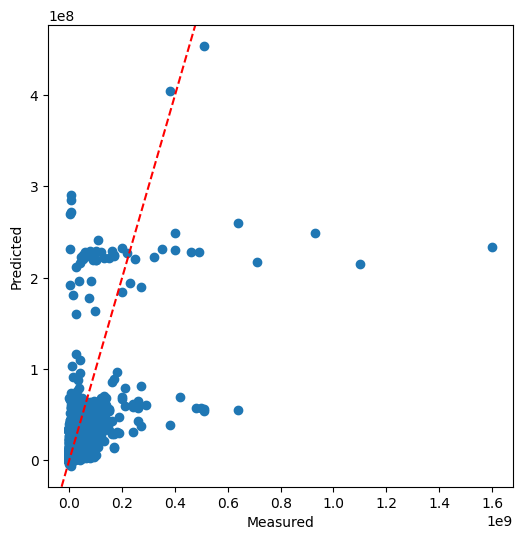

In [6]:
from sklearn.linear_model import LassoLarsCV

new3_list_of_models = [
    Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', LassoLarsCV())
    ]),
]

for model in new3_list_of_models:
    hist = model.fit(X_train, y_train)
    print(model[2])
    print("score: ", hist.score(X_test, y_test))
    predicted = model.predict(X_test)
    actual = y_test

    f, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(actual, predicted)
    axline((0, 0), (1, 1), color='r', linestyle='--')
    ax.set_xlabel("Measured")
    ax.set_ylabel("Predicted")
    plt.show()

StackingRegressor(cv=5,
                  estimators=[('gb_reg', GradientBoostingRegressor()),
                              ('dnn_reg',
                               KerasRegressor(epochs=50, model=<function build_dnn at 0x00000277A6803060>, verbose=False)),
                              ('gamma_reg', GammaRegressor()),
                              ('poisson_reg', PoissonRegressor(max_iter=3000))],
                  final_estimator=GradientBoostingRegressor(), n_jobs=-1)
score:  0.48504285566274763


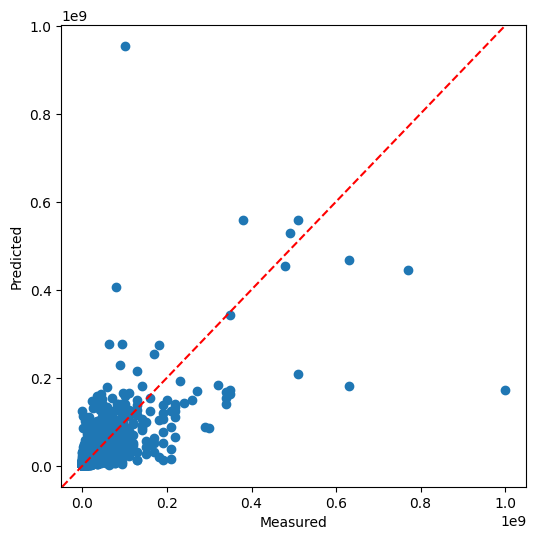

In [2]:
from sklearn.linear_model import GammaRegressor, PoissonRegressor, TweedieRegressor
from sklearn.ensemble import StackingRegressor

def build_dnn(meta): 
    model= keras.models.Sequential([
                    keras.layers.Dense(200,activation='leaky_relu', input_dim=meta["n_features_in_"]),
                    keras.layers.LayerNormalization(),
                    keras.layers.Dense(400,activation='leaky_relu'),
                    keras.layers.Dropout(0.2),
                    keras.layers.Dense(600,activation='leaky_relu'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(400,activation='leaky_relu'),
                    keras.layers.Dropout(0.2),
                    keras.layers.Dense(200,activation='leaky_relu'),
                    keras.layers.Dense(100,activation='leaky_relu'),
                    keras.layers.Dropout(0.2),
                    keras.layers.Dense(50,activation='leaky_relu'),
                    keras.layers.Dense(1, activation='linear')
        ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001),
            loss='mean_squared_error',
            metrics=['RootMeanSquaredError'])
    return model

def run_model_4():
    gb_reg = GradientBoostingRegressor()
    gamma_reg = GammaRegressor()
    poisson_reg = PoissonRegressor(max_iter=3000)
    dnn_reg = KerasRegressor(build_dnn, epochs=50, verbose=False)
    estimators = [ ('gb_reg', gb_reg), ('dnn_reg', dnn_reg),
                  ('gamma_reg', gamma_reg), ('poisson_reg', poisson_reg)]
    stacking_reg = StackingRegressor(estimators=estimators, final_estimator=GradientBoostingRegressor(), cv=5, n_jobs=-1)

    model = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', stacking_reg)
    ])

    hist = model.fit(X_train, y_train)
    print(model[2])
    print("score: ", hist.score(X_test, y_test))
    predicted = model.predict(X_test)
    actual = y_test

    f, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(actual, predicted)
    axline((0, 0), (1, 1), color='r', linestyle='--')
    ax.set_xlabel("Measured")
    ax.set_ylabel("Predicted")
    plt.show()

run_model_4()

TweedieRegressor(max_iter=1500, power=2)
score:  0.5025274740361612


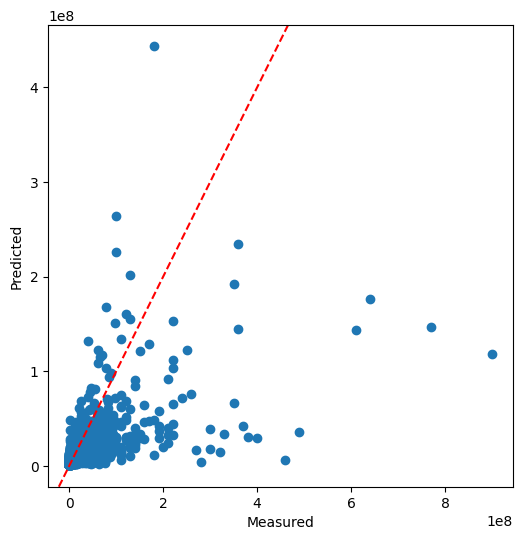

TweedieRegressor(max_iter=3000, power=1)
score:  0.6538182460305113


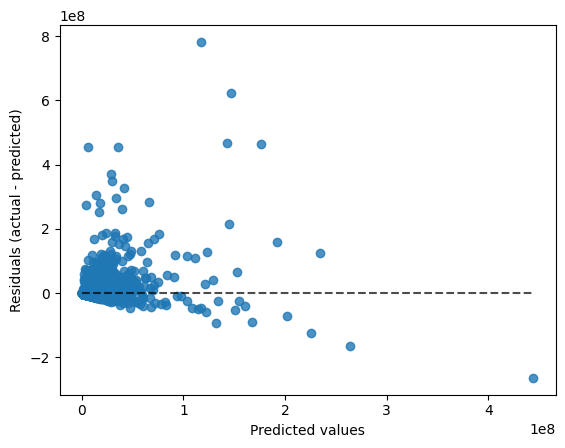

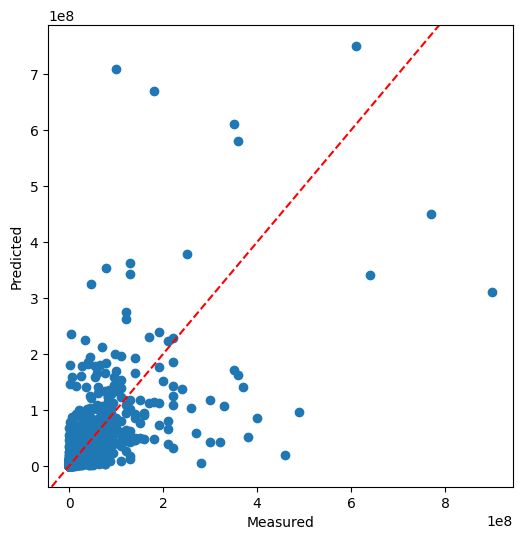

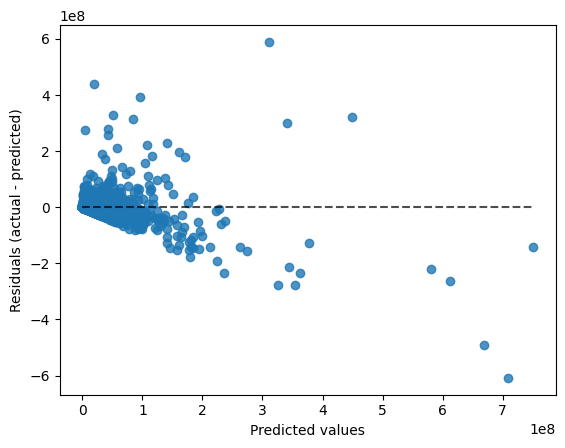

In [3]:
from sklearn.metrics import PredictionErrorDisplay

from sklearn.linear_model import TweedieRegressor

new4_list_of_models = [
    Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', TweedieRegressor(power=2, max_iter=1500))
    ]),
    Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', TweedieRegressor(power=1, max_iter=3000))
    ]),
]

for model in new4_list_of_models:
    hist = model.fit(X_train, y_train)
    print(model[2])
    print("score: ", hist.score(X_test, y_test))
    predicted = model.predict(X_test)
    actual = y_test

    f, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(actual, predicted)
    axline((0, 0), (1, 1), color='r', linestyle='--')
    ax.set_xlabel("Measured")
    ax.set_ylabel("Predicted")
    plt.show()

    display = PredictionErrorDisplay(y_true=actual, y_pred=predicted)
    display.plot()

HistGradientBoostingRegressor(random_state=29)
score:  0.3925875779382578
R-square (R2): 0.3925875779382578
Median absolute error: 2654194.122638261
Root mean squared error: 19485174.858069684
(array([ 4562,  5127, 11311], dtype=int64),)


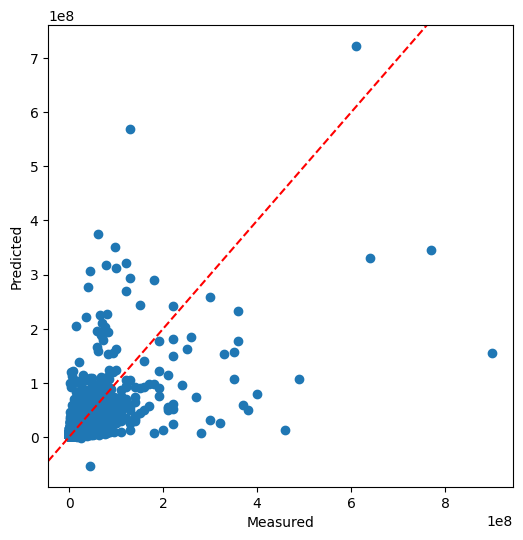

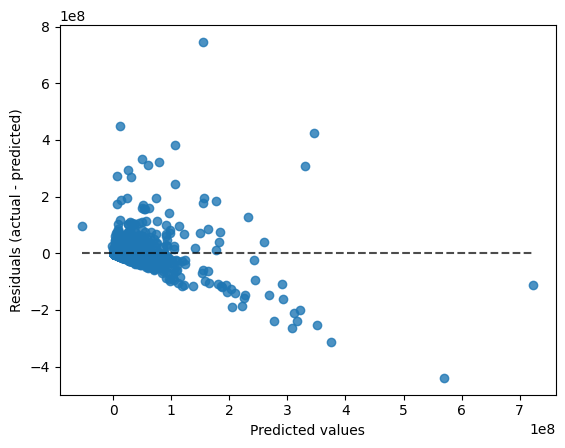

              Price      diff_abs     predicted       actual
576   -7.456733e+08  7.456733e+08  1.543267e+08  900000000.0
3734  -4.478087e+08  4.478087e+08  1.219131e+07  460000000.0
8966   4.399043e+08  4.399043e+08  5.699043e+08  130000000.0
39817 -4.241582e+08  4.241582e+08  3.458418e+08  770000000.0
28144 -3.834934e+08  3.834934e+08  1.065066e+08  490000000.0
52885 -3.313214e+08  3.313214e+08  4.867860e+07  380000000.0
31918 -3.210510e+08  3.210510e+08  7.894898e+07  400000000.0
1093   3.131827e+08  3.131827e+08  3.741827e+08   61000000.0
680   -3.108503e+08  3.108503e+08  5.914969e+07  370000000.0
9363  -3.090654e+08  3.090654e+08  3.309346e+08  640000000.0
9142  -2.953084e+08  2.953084e+08  2.469162e+07  320000000.0
56143 -2.727734e+08  2.727734e+08  7.226586e+06  280000000.0
30160 -2.698335e+08  2.698335e+08  3.016653e+07  300000000.0
32311  2.634861e+08  2.634861e+08  3.074861e+08   44000000.0
6652   2.538134e+08  2.538134e+08  3.508134e+08   97000000.0
36568 -2.428705e+08  2.4

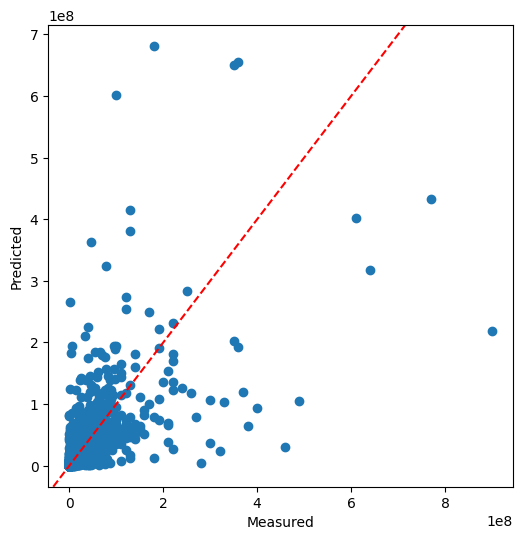

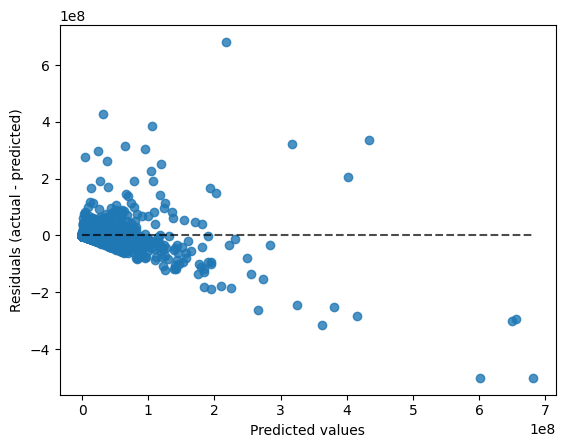

              Price      diff_abs     predicted       actual
576   -6.819010e+08  6.819010e+08  2.180990e+08  900000000.0
5993   5.017663e+08  5.017663e+08  6.017663e+08  100000000.0
35882  5.016766e+08  5.016766e+08  6.816766e+08  180000000.0
3734  -4.288587e+08  4.288587e+08  3.114132e+07  460000000.0
28144 -3.844837e+08  3.844837e+08  1.055163e+08  490000000.0
39817 -3.370627e+08  3.370627e+08  4.329373e+08  770000000.0
9363  -3.223872e+08  3.223872e+08  3.176128e+08  640000000.0
8341   3.153023e+08  3.153023e+08  3.623023e+08   47000000.0
52885 -3.147741e+08  3.147741e+08  6.522592e+07  380000000.0
31918 -3.056457e+08  3.056457e+08  9.435427e+07  400000000.0
36568  3.002633e+08  3.002633e+08  6.502633e+08  350000000.0
9142  -2.962281e+08  2.962281e+08  2.377195e+07  320000000.0
46     2.959131e+08  2.959131e+08  6.559131e+08  360000000.0
8966   2.852868e+08  2.852868e+08  4.152868e+08  130000000.0
56143 -2.752939e+08  2.752939e+08  4.706069e+06  280000000.0
41110  2.639278e+08  2.6

In [4]:
from sklearn.metrics import r2_score, median_absolute_error, root_mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import QuantileTransformer

new5_list_of_models = [
    Pipeline([
        ('model', HistGradientBoostingRegressor(random_state=29))
    ]),
    Pipeline([
        ('transformer_in', ColumnTransformer([
            ("categorical", "passthrough", df_japan.select_dtypes(include='bool').columns),
            ("numerical_input", KNNImputer(missing_values=np.nan), df_japan.select_dtypes(include=['float64', 'int64']).columns),
        ])),
        ("q_transformer", QuantileTransformer(output_distribution='normal', random_state=29)),
        ('scaler', StandardScaler()),
        ('model', TweedieRegressor(power=1, max_iter=6000))
    ]),
]

for model in new5_list_of_models:
    print(model[-1])
    hist = model.fit(X_train, y_train)
    print("score: ", hist.score(X_test, y_test))
    predicted = model.predict(X_test)
    actual = y_test

    r2 = r2_score(actual, predicted)
    mae = median_absolute_error(actual, predicted)
    rmse = root_mean_squared_error(actual, predicted)
    print(f"R-square (R2): {r2}")
    print(f"Median absolute error: {mae}")
    print(f"Root mean squared error: {rmse}")
    print(np.where(predicted < 0))

    f, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(actual, predicted)
    axline((0, 0), (1, 1), color='r', linestyle='--')
    ax.set_xlabel("Measured")
    ax.set_ylabel("Predicted")

    display = PredictionErrorDisplay(y_true=actual, y_pred=predicted)
    display.plot()
    plt.show()

    difference = pd.DataFrame(np.subtract(predicted, actual))
    difference["diff_abs"] = difference["Price"].abs()
    difference["predicted"] = predicted
    difference["actual"] = actual
    difference.sort_values(by="diff_abs",ascending=False, inplace=True)
    print(difference.head(50))
    print(df_japan_copy.iloc[difference.head(50).index])
    print(df_japan_copy.iloc[difference.head(50).index]["ID"])

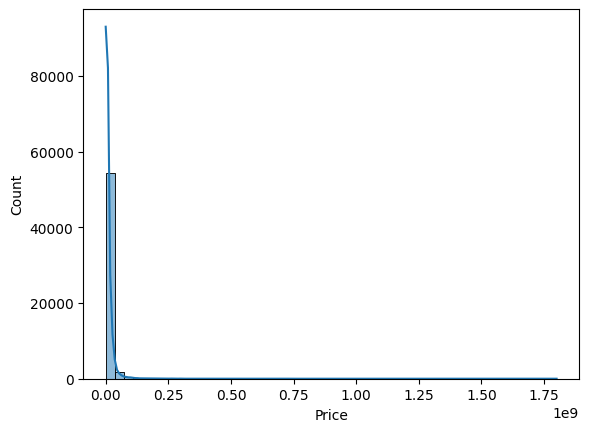

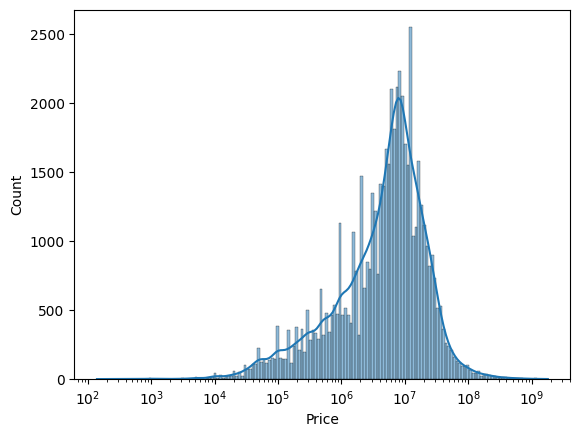

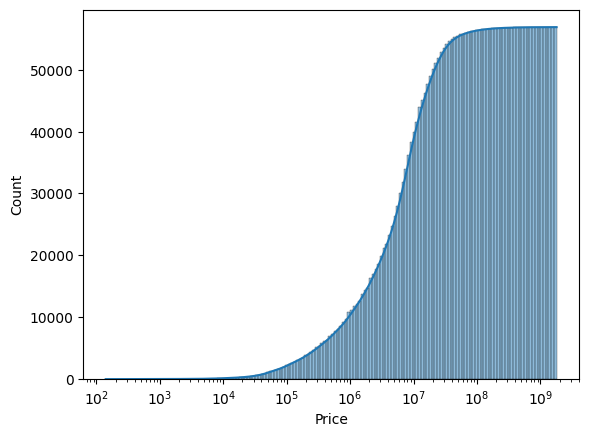

In [5]:
sns.histplot(price, kde=True, bins=50)
plt.show()

sns.histplot(price, kde=True, log_scale=True)
plt.show()

sns.histplot(price, kde=True, log_scale=True, cumulative=True)
plt.show()